# Chladni Modes and Laplacian Spectrum

In [13]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
path_chladni = PATHDATA / 'chladni'
path_plotchladni = PATHPLOT / 'chladni'

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


## Energy plots

### Energy and magnetization

In [2]:
remove_files = False
geo = 'sqr'
side_list = [32, 64, 128]

In [3]:
l = {}
test_ene = {}
for side in side_list:
    fname = f'Lattice2D{geo}_wspect_{side}.pkl'
    pname = path_chladni / f'Lattice2D{geo}_wspect_{side}.pkl'
    if os.path.exists(pname):
        l[side] = pk.load(open(pname, 'rb'))
    else:
        l[side] = Lattice2D(side, geo=geo)
        l[side].compute_k_eigvV(with_routine='numpy')
        for _ in range(l[side].N):
            l[side].compute_rbim_energy_eigV(_)
        with open(pname, 'wb') as f:
            pk.dump(l[side], f)
    test_ene[side] = [l[side].get_rbim_energy_eigV(_)/(2*l[side].N) for _ in range(l[side].N)]

In [7]:
## here read magnresults

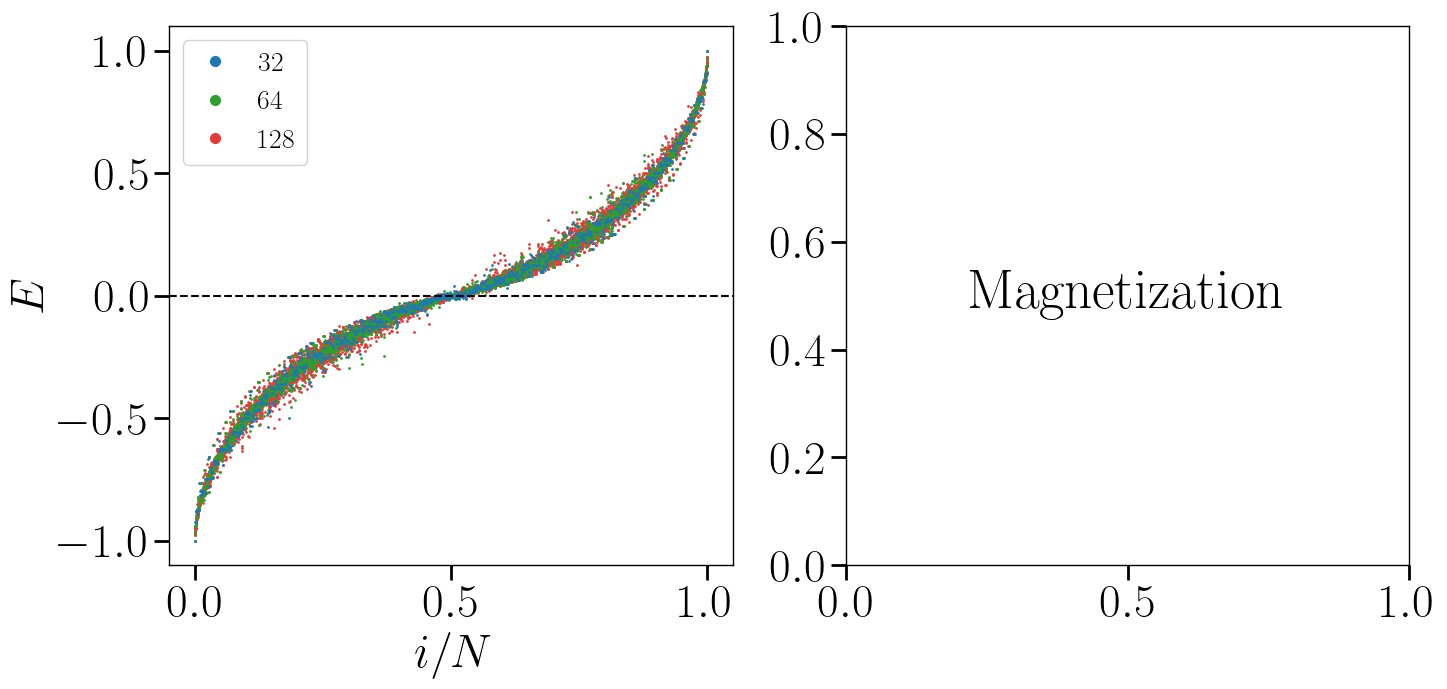

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 7))
for side in side_list:
    ax[0].plot(np.linspace(0, 1, num=len(test_ene[side])), np.array(test_ene[side]), 'o', ms=1, label=f'{side}', zorder=1/side)
ax[0].axhline(0, ls='--', color='k')
ax[0].set_ylabel(r'$E$')
ax[0].set_xlabel(r'$i/N$')
ax[0].legend(fontsize=20, markerscale=7.,)
ax[1].text(0.5, 0.5, 'Magnetization', transform=ax[1].transAxes, fontsize=40, va='center', ha='center')

fig.savefig(path_plotchladni / f'rbim_energy_{geo}.pdf', bbox_inches='tight', 
            transparent=True)

In [7]:
lattice = l[128]
list_eigv = [1, lattice.N//64, lattice.N//4, lattice.N//2, 3*lattice.N//4]

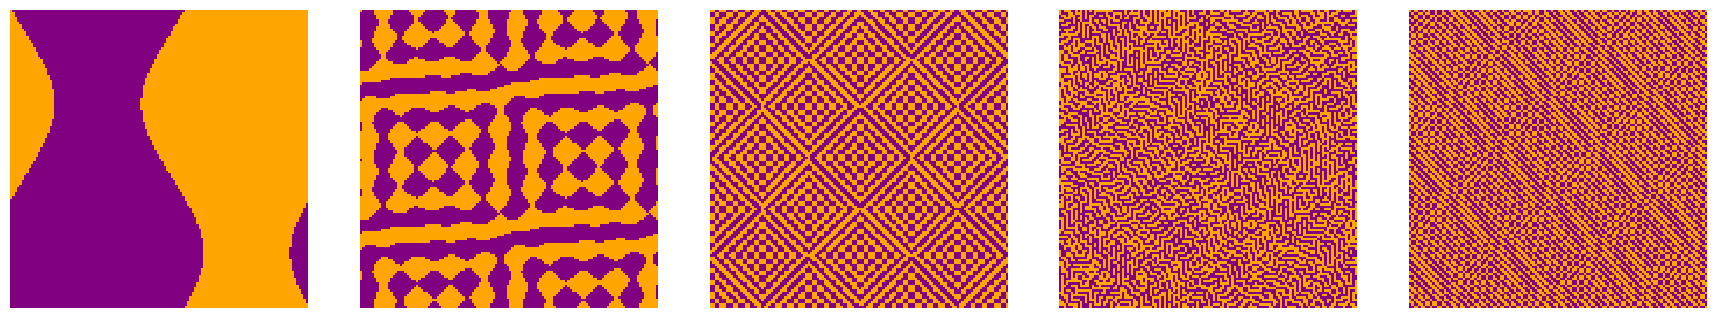

In [39]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))
cmap = ListedColormap(['purple', 'orange'])
for j,eigvn in enumerate(list_eigv):
    ax[j].imshow(lattice.get_eigV_bin_check(eigvn).reshape(*lattice.syshape), origin='lower', interpolation='none', cmap=cmap)
    ax[j].axis('off')
fig.tight_layout()
fig.savefig(path_plotchladni / f'rbim_eigv_{geo}.pdf', bbox_inches='tight', transparent=True)

### Eigenstates Supplementary

In [11]:
list_eigv = np.linspace(1, 3*lattice.N//4, num=25, dtype=int)

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
cmap = ListedColormap(['purple', 'orange'])
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(lattice.get_eigV_bin_check(list_eigv[count]).reshape(*lattice.syshape), origin='lower', interpolation='none', cmap=cmap)
        ax[i,j].axis('off')
        ax[i, j].set_title(f'${list_eigv[count]/lattice.N:.2}$')
        count += 1
fig.tight_layout()

In [30]:
def spin_overlap(S1, S2):
     # Ensure both matrices have the same shape
     assert S1.shape == S2.shape, "Matrices must have the same shape!"

     # Direct overlap
     direct_overlap = np.sum(S1 * S2) / S1.size

     # Flipped overlap (inverted spins)
     flipped_overlap = np.sum(S1 * (-S2)) / S1.size

     # Return the maximum overlap, accounting for possible inversion
     return max(direct_overlap, flipped_overlap)

def matrix_projection(M, basis):
     projections = []

     # Iterate over each basis matrix
     for B_i in basis:
         # Compute the inner product between M and B_i
         inner_product = np.sum(M * B_i)

         # Compute the Frobenius norm of the basis matrix B_i
         norm_Bi = np.linalg.norm(B_i)

         # Compute the projection (normalized inner product)
         projection_i = inner_product / norm_Bi

         # Append the projection to the result list
         projections.append(projection_i)

     return projections
def reconstruct_from_projections(projections, basis):
     # Initialize the reconstructed matrix as zero
     reconstructed_matrix = np.zeros_like(basis[0])

     # Multiply each projection by its corresponding basis matrix and sum
     for i, B_i in enumerate(basis):
         reconstructed_matrix += projections[i] * B_i

     return reconstructed_matrix
def elements_within_eta_numpy(array, eta):
    """
    Returns elements in the array that are within eta from the minimum value.
    
    Parameters:
    - array (array-like): Input array of numerical values.
    - eta (float): Threshold value.
    
    Returns:
    - filtered_elements (np.ndarray): Elements within eta from the minimum.
    """
    array = np.array(array)  # Ensure input is a NumPy array
    min_val = np.min(array)
    displacement = array - min_val
    mask = displacement <= eta
    filtered_elements = array[mask]
    return filtered_elements

### Antiferro Reconstruction

In [63]:
T = 0.
geo = 'tri'
pflip = 1
remove_files = False
side = 64

In [64]:
l_tri_recon = Lattice2D(side, geo=geo, pflip=1)
l_tri_recon.flip_random_fract_edges()
l_tri_recon.compute_k_eigvV(with_routine='numpy')

In [76]:
isdy = IsingDynamics(l_tri_recon, T=T, ic='ground_state_0', runlang='C3', rndStr=True)
isdy.init_ising_dynamics()
l_tri_recon.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=80)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    l_tri_recon.remove_edgl_file()

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(l_tri_recon.get_eigV_bin_check(0).reshape(*l_tri_recon.syshape))
ax[1].imshow(isdy.s.reshape(*l_tri_recon.syshape))

In [80]:
# overlap = np.array([spin_overlap(isdy.s.reshape(*l.syshape),l.get_eigV_bin_check(i).reshape(*l.syshape)) for i in range(l.N)])
# sorted_args = np.argsort(overlap)[::-1]
matproj = isdy.s.reshape(*l_tri_recon.syshape)
basis = np.array([l_tri_recon.eigV[i].reshape(*l_tri_recon.syshape) for i in range(256)])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
recon = np.sign(reconstruct_from_projections(projections, basis))
ax[0].imshow(recon, origin='lower')
ax[1].imshow(isdy.s.reshape(*l_tri_recon.syshape), origin='lower')
p_overlap = spin_overlap(isdy.s.reshape(*l_tri_recon.syshape), recon)
print(p_overlap)

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(-l.get_eigV_bin_check(sorted_args[i]).reshape(*l.syshape), origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'{sorted_args[i]}')
ax[3].imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax[3].axis('off')
ax[4].imshow(np.sign(reconstruct_from_projections(projections, basis)), origin='lower')
ax[4].axis('off')

## SL

In [91]:
lsl = Lattice2D(64, pflip=0.2, geo='sqr')
lsl.flip_random_fract_edges()

In [92]:
lsl.compute_k_eigvV(with_routine='numpy')

In [93]:
isdy = IsingDynamics(lsl, T=0.5, ic='uniform', runlang='C3', rndStr=True)

In [94]:
isdy.init_ising_dynamics()
lsl.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=80)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    lsl.remove_edgl_file()

In [97]:
matproj = isdy.s.reshape(*lsl.syshape)
basis = np.array([lsl.eigV[i].reshape(*lsl.syshape) for i in range(256)])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
recon = np.sign(reconstruct_from_projections(projections, basis))
ax[0].imshow(recon, origin='lower')
ax[1].imshow(isdy.s.reshape(*l_tri_recon.syshape), origin='lower')
p_overlap = spin_overlap(isdy.s.reshape(*l_tri_recon.syshape), recon)
print(p_overlap)

In [104]:
ll = Lattice2D(64)
ll.compute_k_eigvV(with_routine='numpy')

In [ ]:
plt.imshow(np.abs(ll.eigV[0].reshape(*ll.syshape)), origin='lower')

## Trash

In [2]:
T = 0.0
geo = 'sqr'
pflip = 0
remove_files = False

In [3]:
l = Lattice2D(64, pflip=pflip, geo=geo)
l.flip_random_fract_edges()
l.compute_k_eigvV(with_routine='numpy')

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 3.5))
count = 0
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(l.get_eigV_bin_check(count).reshape(*l.syshape), origin='lower')
        ax[i, j].axis('off')
        ax[i, j].set_title(f'{count}')
        count += 1

In [ ]:
test_ene = [l.get_rbim_energy_eigV(_)/(2*l.N) for _ in range(l.N)]
plt.plot(test_ene, 'o', ms=0.5)

In [140]:
isdy = IsingDynamics(l, T=T, ic='ground_state_0', runlang='C3', rndStr=True)
isdy.init_ising_dynamics()
l.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=200)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    l.remove_edgl_file()

In [ ]:
4096*3000

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(l.get_eigV_bin_check(1023).reshape(*l.syshape))
ax[1].imshow(isdy.s.reshape(*l.syshape))

In [ ]:
np.exp(-1/0.1), 1/4096

In [95]:
ene = np.fromfile(l.isingpath /Path('ene_p=0_T=0_.bin'), dtype=np.float64)

In [ ]:
l.get_rbim_energy_eigV(2048)/(2*l.N)

In [ ]:
plt.plot(ene/(4))
# plt.yscale('symlog')
plt.xscale('symlog')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax.axis('off')

In [2]:
overlap = np.array([spin_overlap(isdy.s.reshape(*l.syshape),l.get_eigV_bin_check(i).reshape(*l.syshape)) for i in range(l.N)])
sorted_args = np.argsort(overlap)[::-1]
matproj = isdy.s.reshape(*l.syshape)
basis = np.array([l.eigV[i].reshape(*l.syshape) for i in sorted_args[:500]])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(-l.get_eigV_bin_check(sorted_args[i]).reshape(*l.syshape), origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'{sorted_args[i]}')
ax[3].imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax[3].axis('off')
ax[4].imshow(np.sign(reconstruct_from_projections(projections, basis)), origin='lower')
ax[4].axis('off')

In [ ]:
spin_overlap(isdy.s.reshape(*l.syshape), np.sign(reconstruct_from_projections(projections, basis)))